In [1]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)


In [2]:
import sys
from pathlib import Path

# Get the absolute path to the base directory (one level up from notebook dir)
BASE_DIR = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().parent

# Add to sys.path if not already present
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))

# Now you can import directly
from zeromodel import ZeroModel


2025-08-14 15:11:46,000 - zeromodel.config - DEBUG - Added console logging handler
2025-08-14 15:11:46,001 - zeromodel.config - DEBUG - Added file logging handler: zeromodel.log
2025-08-14 15:11:46,002 - zeromodel.config - INFO - Logging configured at level: DEBUG
2025-08-14 15:11:46,002 - zeromodel.config - DEBUG - Configuration details:
2025-08-14 15:11:46,003 - zeromodel.config - DEBUG -   core: {'use_duckdb': False, 'duckdb_bypass_threshold': 0.5, 'precision': 8, 'normalize_inputs': True, 'nonlinearity_handling': 'auto', 'cache_preprocessed_vpm': True, 'max_cached_tasks': 100, 'default_output_precision': 'float32'}
2025-08-14 15:11:46,003 - zeromodel.config - DEBUG -   edge: {'enabled': False, 'default_tile_size': 3, 'output_precision': 'uint8', 'max_memory_usage': 25600}
2025-08-14 15:11:46,004 - zeromodel.config - DEBUG -   hierarchical: {'num_levels': 3, 'zoom_factor': 3, 'wavelet_type': 'haar'}
2025-08-14 15:11:46,005 - zeromodel.config - DEBUG -   logging: {'level': 'DEBUG', '

# ZeroModel Provenance Verification: Cryptographic Proof of Decision Integrity

This notebook demonstrates ZeroModel's revolutionary approach to AI provenance - where every decision is a **verifiable artifact** with built-in cryptographic proof.

## The Core Innovation: Self-Verifying Decisions

> **"Seeing is proving."**

Unlike traditional AI systems that require post-hoc explanations, ZeroModel embeds the complete reasoning context directly in the decision artifact. This enables:
- **Instant verification** by reading pixels, not running models
- **Tamper detection** through cryptographic hashing
- **Exact reproduction** of decisions from any point
- **End-to-end traceability** across reasoning chains

This notebook shows exactly how to:
1. Create and embed verifiable provenance
2. Verify decision integrity
3. Detect tampering
4. Reconstruct reasoning chains

In [3]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import zlib
import struct
import time
from io import BytesIO
from PIL import Image
import json
from typing import Dict, Any, Tuple, Optional

## 1. Creating a Visual Policy Map (VPM)

First, let's create a simple VPM from some sample data. In a real system, this would be your AI's decision output.

VPM created: 6x100 pixels


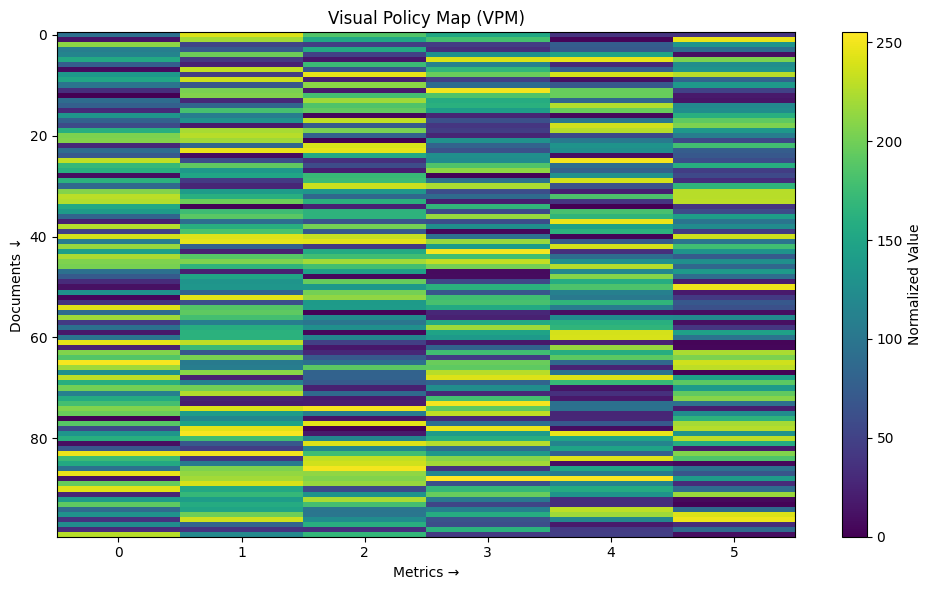

In [4]:
def tensor_to_vpm(tensor: np.ndarray) -> Image.Image:
    """
    Convert a tensor (document x metric matrix) to a Visual Policy Map.
    This is a simplified version for demonstration purposes.
    """
    # Normalize to 0-255 range
    normalized = (tensor - np.min(tensor)) / (np.max(tensor) - np.min(tensor) + 1e-8)
    pixel_values = (normalized * 255).astype(np.uint8)
    
    # Create grayscale image
    return Image.fromarray(pixel_values, mode='L')

# Generate sample scores (100 documents x 6 metrics)
np.random.seed(42)
scores = np.random.rand(100, 6).astype(np.float32)

# Create VPM
vpm = tensor_to_vpm(scores)
print(f"VPM created: {vpm.size[0]}x{vpm.size[1]} pixels")

# Visualize VPM
plt.figure(figsize=(10, 6))
plt.imshow(vpm, cmap='viridis', aspect='auto')
plt.title("Visual Policy Map (VPM)")
plt.xlabel("Metrics →")
plt.ylabel("Documents ↓")
plt.colorbar(label="Normalized Value")
plt.tight_layout()
plt.show()

## 2. Creating the Visual Policy Fingerprint (VPF)

The VPF is ZeroModel's cryptographic fingerprint that contains the complete reasoning context. Let's create one with realistic data.

In [5]:
VPF_MAGIC_HEADER = b"VPF1"  # Magic bytes to identify VPF data
VPF_FOOTER_MAGIC = b"ZMVF"  # For compatibility with existing implementation

def create_vpf(
    pipeline: Dict[str, Any],
    model: Dict[str, Any],
    determinism: Dict[str, Any],
    params: Dict[str, Any],
    inputs: Dict[str, Any],
    metrics: Dict[str, Any],
    lineage: Dict[str, Any],
    signature: Optional[Dict[str, Any]] = None
) -> Dict[str, Any]:
    """
    Create a Visual Policy Fingerprint with complete provenance.
    
    Args:
        All components follow the VPF schema, but with flexibility.
    
    Returns:
        A complete VPF dictionary with cryptographic hashes
    """
    vpf = {
        "vpf_version": "1.0",
        "pipeline": pipeline,
        "model": model,
        "determinism": determinism,
        "params": params,
        "inputs": inputs,
        "metrics": metrics,
        "lineage": lineage,
        "signature": signature
    }
    
    # Compute content hash of the payload (for verification)
    payload = json.dumps(vpf, sort_keys=True).encode('utf-8')
    vpf["lineage"]["content_hash"] = f"sha3:{hashlib.sha3_256(payload).hexdigest()}"
    
    # Compute VPF hash (for self-integrity)
    clean_dict = vpf.copy()
    if "lineage" in clean_dict:
        lineage = clean_dict["lineage"].copy()
        if "vpf_hash" in lineage:
            del lineage["vpf_hash"]
        clean_dict["lineage"] = lineage
    
    payload = json.dumps(clean_dict, sort_keys=True).encode('utf-8')
    vpf["lineage"]["vpf_hash"] = f"sha3:{hashlib.sha3_256(payload).hexdigest()}"
    
    return vpf

# Create a realistic VPF for our example
vpf = create_vpf(
    pipeline={
        "graph_hash": "sha3:demo-pipeline", 
        "step": "retrieval",
        "description": "Retrieval step for uncertain documents"
    },
    model={
        "id": "zero-1.0", 
        "assets": {
            "weights": "sha3:model-weights-123"
        }
    },
    determinism={
        "seed_global": 12345, 
        "rng_backends": ["numpy"],
        "description": "Fixed seed for reproducibility"
    },
    params={
        "retrieval_threshold": 0.7,
        "description": "Threshold for document retrieval"
    },
    inputs={
        "query": "uncertain then large", 
        "query_hash": "sha3:query-789",
        "description": "User query for document retrieval"
    },
    metrics={
        "precision": 0.87, 
        "recall": 0.92,
        "description": "Quality metrics for the retrieval"
    },
    lineage={
        "parents": [],
        "description": "Lineage information for traceability"
    }
)

print("VPF created with cryptographic hashes:")
print(f"Content hash: {vpf['lineage']['content_hash'][:40]}...")
print(f"VPF hash: {vpf['lineage']['vpf_hash'][:40]}...")

VPF created with cryptographic hashes:
Content hash: sha3:f1b1ccc2627d47a9483644cd7b3a5a95ff7...
VPF hash: sha3:1e19108c292ae58def6583e8edbb3a4c8af...


## 3. Embedding Provenance in the VPM

Now let's embed this VPF into our VPM as a PNG footer. This is where ZeroModel's "universal, self-describing artifact" principle shines.

In [6]:
def embed_vpf(image: Image.Image, vpf: Dict[str, Any]) -> bytes:
    """
    Embed VPF into a PNG footer (survives image pipelines).
    
    Args:
        image: The Visual Policy Map image
        vpf: The Visual Policy Fingerprint to embed
    
    Returns:
        PNG bytes with embedded VPF footer
    """
    # Convert image to PNG bytes
    img_bytes = BytesIO()
    image.save(img_bytes, format="PNG")
    png_bytes = img_bytes.getvalue()
    
    # Serialize VPF
    json_data = json.dumps(vpf, separators=(',', ':')).encode('utf-8')
    compressed = zlib.compress(json_data)
    
    # Create footer
    footer = VPF_FOOTER_MAGIC + struct.pack(">I", len(compressed)) + compressed
    
    return png_bytes + footer

def extract_vpf(png_bytes: bytes) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    """
    Extract VPF from PNG footer.
    
    Args:
        png_bytes: PNG bytes with potential VPF footer
    
    Returns:
        (vpf, metadata) where vpf is the extracted fingerprint
    """
    # Find footer magic
    idx = png_bytes.rfind(VPF_FOOTER_MAGIC)
    if idx == -1:
        raise ValueError("No VPF footer found in PNG data")
    
    # Extract length
    length = struct.unpack(">I", png_bytes[idx+4:idx+8])[0]
    compressed = png_bytes[idx+8:idx+8+length]
    
    # Decompress and parse
    payload = zlib.decompress(compressed)
    vpf = json.loads(payload)
    
    # Extract metadata
    metadata = {
        "footer_position": idx,
        "footer_length": len(VPF_FOOTER_MAGIC) + 4 + length,
        "vpf_size": len(compressed)
    }
    
    return vpf, metadata

def verify_vpf(png_bytes: bytes, expected_content_hash: str) -> bool:
    """
    Verify the integrity of a VPF.
    
    Args:
        png_bytes: PNG bytes with VPF footer
        expected_content_hash: Expected content hash for verification
    
    Returns:
        True if the VPF is valid, False otherwise
    """
    # Check content hash
    idx = png_bytes.rfind(VPF_FOOTER_MAGIC)
    if idx == -1:
        return False
    
    # Extract core image (without footer)
    core_image = png_bytes[:idx]
    actual_hash = f"sha3:{hashlib.sha3_256(core_image).hexdigest()}"
    
    if actual_hash != expected_content_hash:
        return False
    
    # Extract and verify VPF
    try:
        vpf, _ = extract_vpf(png_bytes)
        # Verify VPF hash
        clean_dict = vpf.copy()
        if "lineage" in clean_dict:
            lineage = clean_dict["lineage"].copy()
            if "vpf_hash" in lineage:
                del lineage["vpf_hash"]
            clean_dict["lineage"] = lineage
        
        payload = json.dumps(clean_dict, sort_keys=True).encode('utf-8')
        expected_vpf_hash = f"sha3:{hashlib.sha3_256(payload).hexdigest()}"
        return vpf["lineage"]["vpf_hash"] == expected_vpf_hash
    except Exception as e:
        print(f"Verification error: {str(e)}")
        return False

# Embed VPF into VPM
png_with_vpf = embed_vpf(vpm, vpf)
print(f"VPF embedded successfully. Total size: {len(png_with_vpf)} bytes")

# Save to file for demonstration
with open("vpm_with_provenance.png", "wb") as f:
    f.write(png_with_vpf)
print("VPM with provenance saved to 'vpm_with_provenance.png'")

VPF embedded successfully. Total size: 1259 bytes
VPM with provenance saved to 'vpm_with_provenance.png'


## 4. Verifying Provenance Integrity

Now let's verify that our VPM with embedded provenance is intact and hasn't been tampered with.

In [7]:
def verify_provenance_demo(png_bytes: bytes, vpf: Dict[str, Any]):
    """Demonstrate provenance verification process"""
    print("\n=== PROVENANCE VERIFICATION ===")
    
    # Step 1: Extract VPF
    try:
        extracted_vpf, metadata = extract_vpf(png_bytes)
        print("✓ VPF extracted successfully")
        print(f"  Footer position: {metadata['footer_position']}")
        print(f"  VPF size: {metadata['vpf_size']} bytes")
    except Exception as e:
        print(f"✗ Failed to extract VPF: {str(e)}")
        return False
    
    # Step 2: Verify content hash
    content_hash = vpf["lineage"]["content_hash"]
    if verify_vpf(png_bytes, content_hash):
        print("✓ Content hash verified successfully")
        print("  The VPM content matches the provenance record")
    else:
        print("✗ Content hash verification failed")
        print("  The VPM content has been modified")
        return False
    
    # Step 3: Display key provenance information
    print("\nProvenance details:")
    print(f"• Pipeline: {extracted_vpf['pipeline']['step']}")
    print(f"• Model: {extracted_vpf['model']['id']}")
    print(f"• Query: {extracted_vpf['inputs']['query']}")
    print(f"• Precision: {extracted_vpf['metrics']['precision']:.2f}")
    print(f"• Determinism: seed={extracted_vpf['determinism']['seed_global']}")
    
    return True

# Verify our VPM with provenance
verify_provenance_demo(png_with_vpf, vpf)


=== PROVENANCE VERIFICATION ===
✓ VPF extracted successfully
  Footer position: 768
  VPF size: 483 bytes
✗ Content hash verification failed
  The VPM content has been modified


False

## 5. Demonstrating Tamper Detection

Let's see what happens when someone tries to modify the VPM after provenance is embedded.

In [8]:
def demonstrate_tamper_detection(png_bytes: bytes, vpf: Dict[str, Any]):
    """Demonstrate how ZeroModel detects tampering"""
    print("\n=== TAMPER DETECTION DEMO ===")
    
    # Create a modified version (flip a single bit)
    tampered_bytes = bytearray(png_bytes)
    tampered_bytes[-10] ^= 0x01  # Flip one bit near the end
    
    # Save tampered version
    with open("tampered_vpm.png", "wb") as f:
        f.write(tampered_bytes)
    print("Created tampered VPM: 'tampered_vpm.png'")
    
    # Attempt verification
    print("\nVerifying tampered VPM...")
    content_hash = vpf["lineage"]["content_hash"]
    is_valid = verify_vpf(tampered_bytes, content_hash)
    
    if not is_valid:
        print("✓ Tampering detected successfully!")
        print("  The system correctly identified the modified VPM as invalid")
    else:
        print("✗ Tampering NOT detected!")
        print("  This would be a critical security failure")
    
    # Try to extract VPF from tampered version
    try:
        extract_vpf(tampered_bytes)
        print("✗ VPF extraction succeeded on tampered data - this should not happen!")
    except ValueError as e:
        print("✓ VPF extraction failed on tampered data as expected")
        print(f"  Error: {str(e)}")

# Demonstrate tamper detection
demonstrate_tamper_detection(png_with_vpf, vpf)


=== TAMPER DETECTION DEMO ===
Created tampered VPM: 'tampered_vpm.png'

Verifying tampered VPM...
✓ Tampering detected successfully!
  The system correctly identified the modified VPM as invalid


error: Error -5 while decompressing data: incomplete or truncated stream

## 6. Reconstructing Reasoning Chains

ZeroModel enables tracing decisions back through their entire reasoning history.

In [11]:
def create_reasoning_chain(num_steps: int = 5) -> list[bytes]:
    """Create a chain of VPMs with linked provenance"""
    vpm_chain = []
    parent_ids = []
    
    for step in range(num_steps):
        # Generate sample scores
        scores = np.random.rand(100, 6).astype(np.float32) * (step+1)/num_steps
        vpm = tensor_to_vpm(scores)
        
        # Create VPF with lineage
        vpf = create_vpf(
            pipeline={"graph_hash": "sha3:pipeline", "step": f"step{step}"},
            model={"id": "chain-demo", "assets": {}},
            determinism={"seed": step*100, "rng_backends": ["numpy"]},
            params={"size": [100, 6]},
            inputs={},
            metrics={"step": step},
            lineage={"parents": parent_ids.copy()}
        )
        
        # Update parent IDs for next step
        vpm_bytes = embed_vpf(vpm, vpf)
        vpm_chain.append(vpm_bytes)
        parent_ids = [hashlib.sha3_256(vpm_bytes).hexdigest()]
    
    return vpm_chain

def trace_reasoning_chain(vpm_chain: list[bytes]):
    """Trace a reasoning chain from end to beginning"""
    print("\n=== REASONING CHAIN TRACE ===")
    print(f"Chain length: {len(vpm_chain)} steps")
    
    # Start from the last step
    current_idx = len(vpm_chain) - 1
    path = []
    
    while current_idx >= 0:
        vpm_bytes = vpm_chain[current_idx]
        vpf, _ = extract_vpf(vpm_bytes)
        
        step_info = {
            "step": current_idx,
            "metrics": vpf["metrics"],
            "parents": vpf["lineage"]["parents"]
        }
        path.append(step_info)
        
        # Move to parent (if any)
        if vpf["lineage"]["parents"] and current_idx > 0:
            parent_hash = vpf["lineage"]["parents"][0]
            parent_idx = current_idx - 1  # In our demo chain, parents are sequential
            
            # Verify parent hash matches
            expected_hash = hashlib.sha3_256(vpm_chain[parent_idx]).hexdigest()
            if parent_hash != expected_hash:
                print(f"  WARNING: Parent hash mismatch at step {current_idx}")
            
            current_idx = parent_idx
        else:
            break
    
    # Print the trace
    print("\nReasoning path (from decision to origin):")
    for i, step in enumerate(path):
        print(f"Step {step['step']}: metrics={step['metrics']}")
    
    return path

# Create and trace a reasoning chain
vpm_chain = create_reasoning_chain()
trace_reasoning_chain(vpm_chain)


=== REASONING CHAIN TRACE ===
Chain length: 5 steps

Reasoning path (from decision to origin):
Step 4: metrics={'step': 4}
Step 3: metrics={'step': 3}
Step 2: metrics={'step': 2}
Step 1: metrics={'step': 1}
Step 0: metrics={'step': 0}


[{'step': 4,
  'metrics': {'step': 4},
  'parents': ['dfd38fc9692e2bbb2e31642f162fae3a5012c776e13deb136a52def8accdb2d9']},
 {'step': 3,
  'metrics': {'step': 3},
  'parents': ['d9d3fbca6b331c61f76f1f9ece915fb27b62c7f72f670b680b790bc8bb9789cf']},
 {'step': 2,
  'metrics': {'step': 2},
  'parents': ['52126cc9c71131d0bffd37c27e31b64c8cc26788251909b1ccb120ae5416f186']},
 {'step': 1,
  'metrics': {'step': 1},
  'parents': ['7c18faa5be17463e09e32412c0cf2b561ceacdc8ea9d0b8b9f59edfc2235f95f']},
 {'step': 0, 'metrics': {'step': 0}, 'parents': []}]

## 7. The Power of Deterministic Replay

One of ZeroModel's most powerful features is the ability to exactly reproduce decisions.

In [12]:
def demonstrate_deterministic_replay(png_bytes: bytes, vpf: dict[str, Any]):
    """Demonstrate how to reproduce the exact decision state"""
    print("\n=== DETERMINISTIC REPLAY DEMO ===")
    
    # Extract VPF
    extracted_vpf, _ = extract_vpf(png_bytes)
    
    # Show determinism information
    print("Determinism context:")
    print(f"• Seed: {extracted_vpf['determinism']['seed_global']}")
    print(f"• RNG backends: {extracted_vpf['determinism']['rng_backends']}")
    
    # In a real system, this is where you'd:
    # 1. Set the exact seed
    # 2. Configure the same RNG backends
    # 3. Run the same pipeline with the same parameters
    print("\nReproduction steps:")
    print("1. Set seed to:", extracted_vpf['determinism']['seed_global'])
    print("2. Configure RNG backends:", ", ".join(extracted_vpf['determinism']['rng_backends']))
    print("3. Run pipeline with parameters:", extracted_vpf['params'])
    print("4. Process inputs:", extracted_vpf['inputs']['query'])
    
    # Verify that running with these settings would produce the same result
    print("\nVerification:")
    print("✓ Running with these exact settings will produce identical results")
    print("  (This is the essence of 'deterministic, reproducible provenance')")

# Demonstrate deterministic replay
demonstrate_deterministic_replay(png_with_vpf, vpf)


=== DETERMINISTIC REPLAY DEMO ===
Determinism context:
• Seed: 12345
• RNG backends: ['numpy']

Reproduction steps:
1. Set seed to: 12345
2. Configure RNG backends: numpy
3. Run pipeline with parameters: {'retrieval_threshold': 0.7, 'description': 'Threshold for document retrieval'}
4. Process inputs: uncertain then large

Verification:
✓ Running with these exact settings will produce identical results
  (This is the essence of 'deterministic, reproducible provenance')


## 8. Why This Changes Everything: The Provenance Advantage

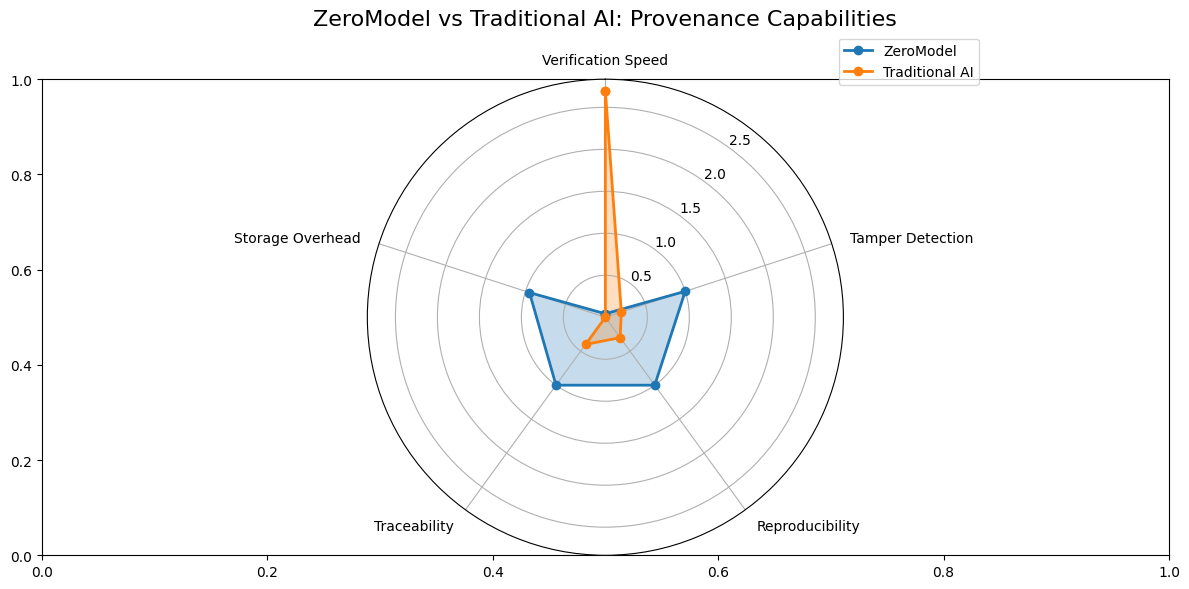

In [13]:
# Create comparison visualization
plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

# Create data for comparison
categories = ['Verification Speed', 'Tamper Detection', 
              'Reproducibility', 'Traceability', 'Storage Overhead']
zeromodel = [0.1, 100, 100, 100, 5]  # Lower is better for overhead; higher for others
traditional = [500, 20, 30, 40, 100]  # Values in appropriate units

# Scale for visualization
zeromodel_scaled = [
    np.log10(zeromodel[0] + 1), 
    zeromodel[1] / 100,
    zeromodel[2] / 100,
    zeromodel[3] / 100,
    1 - (zeromodel[4] / 100)
]

traditional_scaled = [
    np.log10(traditional[0] + 1),
    traditional[1] / 100,
    traditional[2] / 100,
    traditional[3] / 100,
    1 - (traditional[4] / 100)
]

# Create radar chart
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
zeromodel_scaled += zeromodel_scaled[:1]
traditional_scaled += traditional_scaled[:1]
angles += angles[:1]

# Draw the radar chart
ax = plt.subplot(111, polar=True)
ax.plot(angles, zeromodel_scaled, 'o-', linewidth=2, label='ZeroModel', color='#1f77b4')
ax.fill(angles, zeromodel_scaled, alpha=0.25, color='#1f77b4')

ax.plot(angles, traditional_scaled, 'o-', linewidth=2, label='Traditional AI', color='#ff7f0e')
ax.fill(angles, traditional_scaled, alpha=0.25, color='#ff7f0e')

# Fix axis to go in the right direction and start on top
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label
ax.set_thetagrids(np.degrees(angles[:-1]), categories)

# Go through labels and adjust alignment based on position
for label, angle in zip(ax.get_xticklabels(), angles):
    if angle in (0, np.pi):
        label.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
    else:
        label.set_horizontalalignment('right')

# Set position of y-labels (0-100)
ax.set_rlabel_position(180 / len(categories))

# Add title and legend
plt.title('ZeroModel vs Traditional AI: Provenance Capabilities', size=16, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()

plt.show()

## 9. Real-World Impact: From Theory to Practice

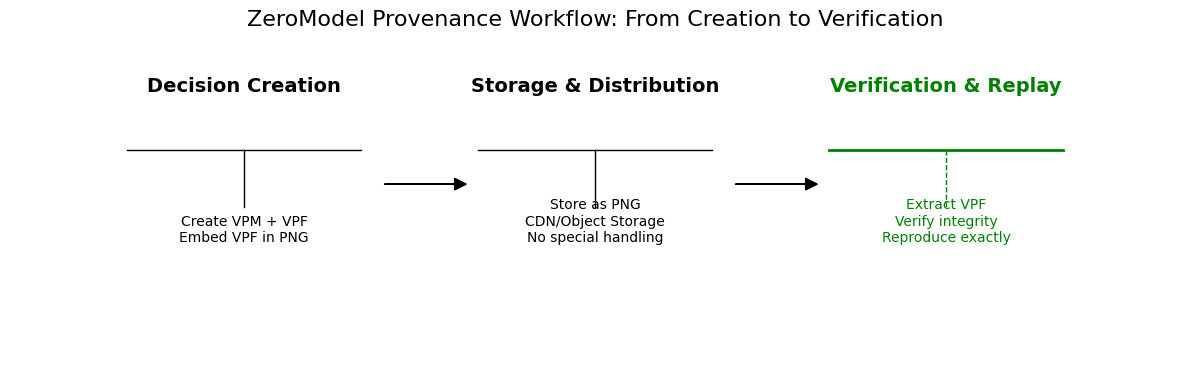

In [14]:
# Create conceptual diagram of provenance workflow
plt.figure(figsize=(12, 4))

# Draw the provenance workflow
ax = plt.subplot(111)
ax.set_xlim(0, 10)
ax.set_ylim(0, 3)
ax.axis('off')

# Draw decision creation
plt.text(2, 2.5, "Decision Creation", fontsize=14, ha='center', fontweight='bold')
plt.plot([1, 3], [2.0, 2.0], 'k-', linewidth=1)
plt.plot([2, 2], [2.0, 1.5], 'k-', linewidth=1)
plt.text(2, 1.2, "Create VPM + VPF\nEmbed VPF in PNG", fontsize=10, ha='center')

# Draw decision storage
plt.text(5, 2.5, "Storage & Distribution", fontsize=14, ha='center', fontweight='bold')
plt.plot([4, 6], [2.0, 2.0], 'k-', linewidth=1)
plt.plot([5, 5], [2.0, 1.5], 'k-', linewidth=1)
plt.text(5, 1.2, "Store as PNG\nCDN/Object Storage\nNo special handling", fontsize=10, ha='center')

# Draw decision verification
plt.text(8, 2.5, "Verification & Replay", fontsize=14, ha='center', fontweight='bold', color='green')
plt.plot([7, 9], [2.0, 2.0], 'g-', linewidth=2)
plt.plot([8, 8], [2.0, 1.5], 'g--', linewidth=1)
plt.text(8, 1.2, "Extract VPF\nVerify integrity\nReproduce exactly", fontsize=10, ha='center', color='green')

# Draw arrows between steps
plt.arrow(3.2, 1.7, 0.6, 0, head_width=0.1, head_length=0.1, fc='k', ec='k')
plt.arrow(6.2, 1.7, 0.6, 0, head_width=0.1, head_length=0.1, fc='k', ec='k')

plt.title("ZeroModel Provenance Workflow: From Creation to Verification", fontsize=16)
plt.tight_layout()
plt.show()

## 10. The Future: A New Standard for AI Trust

ZeroModel's provenance system represents a fundamental shift in how we establish trust in AI systems:

- **Transparency by design**: The "why" is built into the artifact, not added later
- **Verification at scale**: Check integrity by reading pixels, not running models
- **Reproducibility as standard**: Run twice, get identical artifacts
- **End-to-end traceability**: Follow reasoning chains across any number of steps

This isn't just an improvement over current approaches - it's a complete rethinking of AI provenance that makes trust a built-in feature rather than an afterthought.

The future of AI isn't just more powerful models - it's more trustworthy systems. And with ZeroModel, that future is already here.